In [6]:
import pandas as pd
import numpy as np
from preProcess_fun import preProcess
%load_ext autoreload
%autoreload 2
path=r"C:\Users\benia\VScodeprojects\Physical_Models\doi_10_5061_dryad_stqjq2c8p__v20240130\dryad"
data=preProcess(path,1)
data['age_type'] = data['age'] + "_" + data['movement']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
age = data['movement'].unique()
print(age)


['crawl' 'swim']


In [8]:
# Drop non-numerical columns
df_numeric = data.select_dtypes(include=[np.number])

# Convert DataFrame to numpy array
M = df_numeric.values
# Calculate the covariance matrix
cov_matrix = df_numeric.cov()
cov_matrix.shape

(10, 10)

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Get the first two eigenvectors
eigenvector_1 = eigenvectors[:, 0]
eigenvector_2 = eigenvectors[:, 1]

# Project the data onto the first two eigenvectors
projected_data = df_numeric.dot(np.array([eigenvector_1, eigenvector_2]).T)


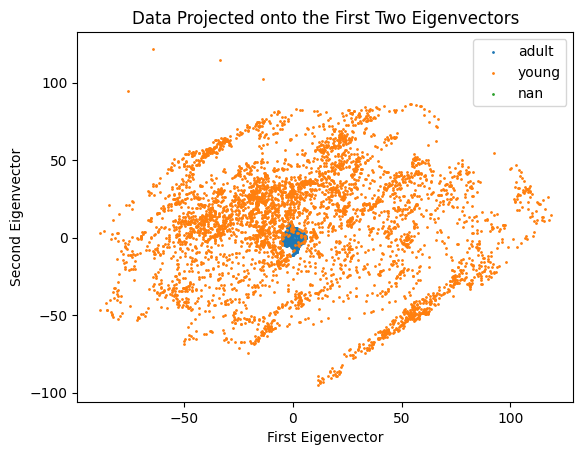

In [12]:
ages = data['age'].unique()

# Create a scatter plot for each age_type
for age in ages:
    mask = data['age'] == age
    plt.scatter(projected_data[0][mask], projected_data[1][mask], label=age,s=1)

plt.xlabel('First Eigenvector')
plt.ylabel('Second Eigenvector')
plt.title('Data Projected onto the First Two Eigenvectors')
plt.legend()  # Add a legend
plt.show()

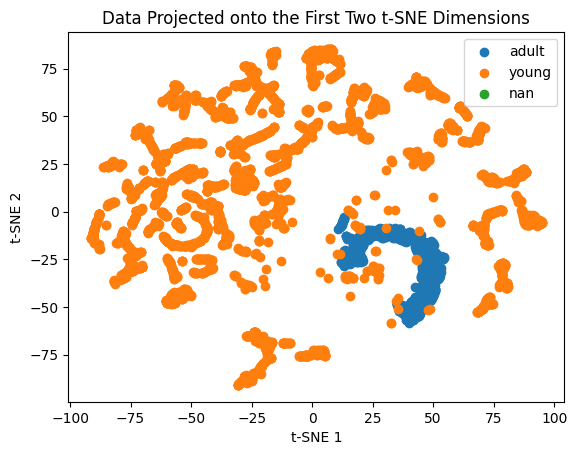

In [11]:
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(df_numeric)

# Plot the t-SNE results
ages = data['age'].unique()
for age in ages:
    mask = data['age'] == age
    plt.scatter(tsne_data[mask, 0], tsne_data[mask, 1], label=age)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Data Projected onto the First Two t-SNE Dimensions')
plt.legend()
plt.show()

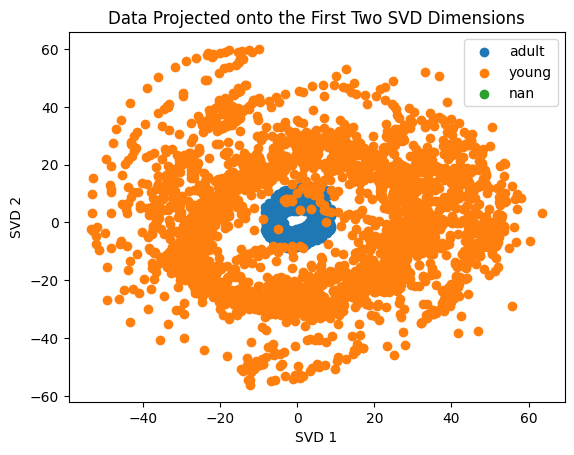

In [17]:
from sklearn.decomposition import TruncatedSVD

# Perform SVD dimensionality reduction
svd = TruncatedSVD(n_components=4)
svd_data = svd.fit_transform(df_numeric)

# Plot the SVD results
for age in ages:
    mask = data['age'] == age
    plt.scatter(svd_data[mask, 0], svd_data[mask, 1], label=age)

plt.xlabel('SVD 1')
plt.ylabel('SVD 2')
plt.title('Data Projected onto the First Two SVD Dimensions')
plt.legend()
plt.show()

In [18]:
import numpy as np

# Compute the SVD
U, S, VT = np.linalg.svd(df_numeric, full_matrices=False)

# The singular values are given by S. To get the singular vectors, you can use U and VT.
# The matrix U contains the left singular vectors, and the matrix VT contains the right singular vectors.

# To get the reduced dimension representation, you can multiply U with S (after reshaping S to a diagonal matrix)
S_diag = np.diag(S)
svd_data_manual = np.dot(U, S_diag)

# Now svd_data_manual contains the same information as svd_data in your original code

In [19]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph
from scipy.linalg import eigh

# Create a graph of nearest neighbors
n_neighbors = 10  # You can adjust this parameter
A = kneighbors_graph(df_numeric, n_neighbors, include_self=False).toarray()

# Compute the degree matrix
D = np.diag(A.sum(axis=1))

# Compute the Laplacian matrix
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigvals, eigvecs = eigh(L)


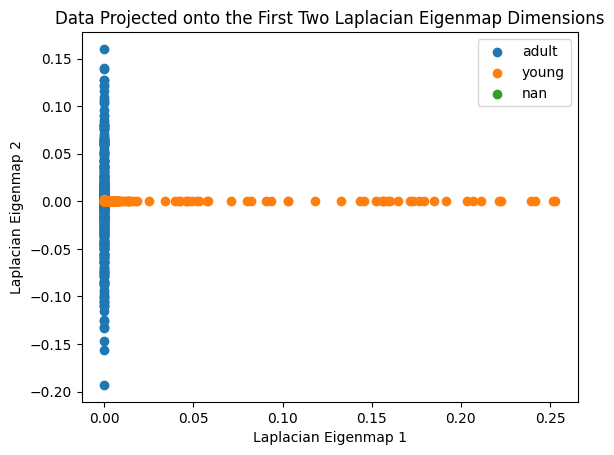

In [24]:

# Select the eigenvectors corresponding to the two smallest eigenvalues (excluding the smallest one which is always zero)
embedding = eigvecs[:, 2:4]

# Plot the results
for age in ages:
    mask = data['age'] == age
    plt.scatter(embedding[mask, 0], embedding[mask, 1], label=age)

plt.xlabel('Laplacian Eigenmap 1')
plt.ylabel('Laplacian Eigenmap 2')
plt.title('Data Projected onto the First Two Laplacian Eigenmap Dimensions')
plt.legend()
plt.show()

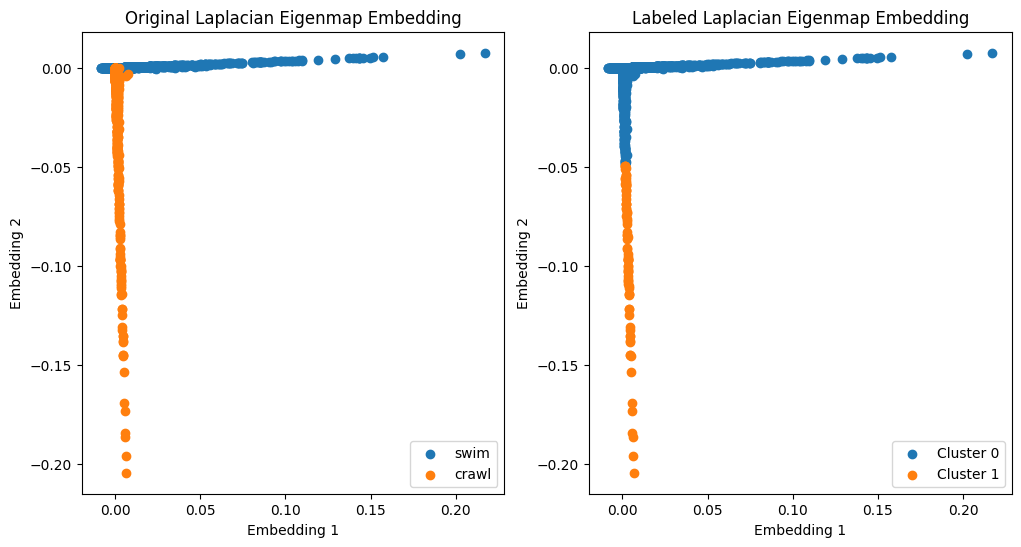

The percentage of mismatched labels is 22.90%


In [170]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# Define KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
# Fit the model to the embedding
kmeans.fit(embedding)

# Get the cluster assignments
clusters = kmeans.labels_

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original embedding in the first subplot
for type in types:
    mask = df['type'] == type
    ax[0].scatter(embedding[mask, 0], embedding[mask, 1], label=type)

ax[0].set_xlabel('Embedding 1')
ax[0].set_ylabel('Embedding 2')
ax[0].set_title('Original Laplacian Eigenmap Embedding')
ax[0].legend()

# Plot the labeled data in the second subplot
for cluster in range(2):
    mask = clusters == cluster
    ax[1].scatter(embedding[mask, 0], embedding[mask, 1], label=f'Cluster {cluster}')

ax[1].set_xlabel('Embedding 1')
ax[1].set_ylabel('Embedding 2')
ax[1].set_title('Labeled Laplacian Eigenmap Embedding')
ax[1].legend()

plt.show()

# Define cluster names
cluster_names = {0: 'swim', 1: 'crawl'}

# Map cluster labels to names
cluster_labels = [cluster_names[label] for label in clusters]

# Create a DataFrame with the true and predicted labels
df_labels = pd.DataFrame({'true': df['type'], 'predicted': cluster_labels})

# Find the percentage of mismatched labels
mismatched = df_labels[df_labels['true'] != df_labels['predicted']]
mismatch_percentage = len(mismatched) / len(df_labels) * 100

print(f'The percentage of mismatched labels is {mismatch_percentage:.2f}%')

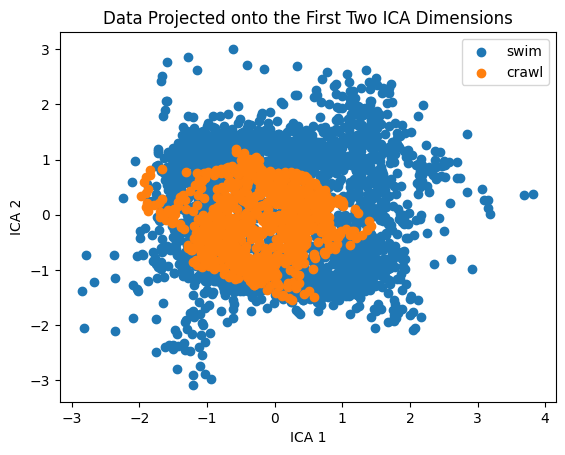

In [117]:
from sklearn.decomposition import FastICA

# Perform ICA dimensionality reduction
ica = FastICA(n_components=4, random_state=0)
ica_data = ica.fit_transform(df_numeric)

# Plot the ICA results
for type in types:
    mask = df['type'] == type
    plt.scatter(ica_data[mask, 0], ica_data[mask, 1], label=type)

plt.xlabel('ICA 1')
plt.ylabel('ICA 2')
plt.title('Data Projected onto the First Two ICA Dimensions')
plt.legend()
plt.show()

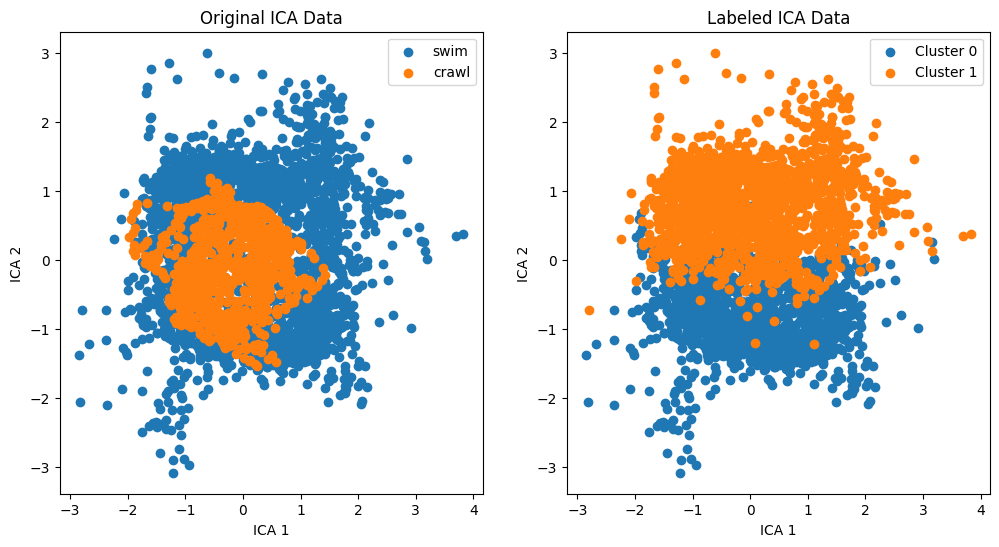

In [147]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define KMeans
kmeans = KMeans(n_clusters=2, random_state=0)

# Fit the model to the ICA data
kmeans.fit(ica_data[:,0:3])

# Get the cluster assignments
clusters = kmeans.labels_

# Define cluster names
cluster_names = {0: 'swim', 1: 'crawl'}

# Map cluster labels to names
cluster_labels = [cluster_names[label] for label in clusters]

# Create a DataFrame with the true and predicted labels
df_labels = pd.DataFrame({'true': df['type'], 'predicted': cluster_labels})

# Find the percentage of mismatched labels
mismatched = df_labels[df_labels['true'] != df_labels['predicted']]
mismatch_percentage = len(mismatched) / len(df_labels) * 100

print(f'The percentage of mismatched labels is {mismatch_percentage:.2f}%')

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original ICA data in the first subplot
for type in types:
    mask = df['type'] == type
    ax[0].scatter(ica_data[mask, 0], ica_data[mask, 1], label=type)

ax[0].set_xlabel('ICA 1')
ax[0].set_ylabel('ICA 2')
ax[0].set_title('Original ICA Data')
ax[0].legend()

# Plot the labeled data in the second subplot
for cluster in range(2):
    mask = clusters == cluster
    ax[1].scatter(ica_data[mask, 0], ica_data[mask, 1], label=f'Cluster {cluster}')

ax[1].set_xlabel('ICA 1')
ax[1].set_ylabel('ICA 2')
ax[1].set_title('Labeled ICA Data')
ax[1].legend()

plt.show()



The percentage of mismatched labels is 53.26%


In [142]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh

# Step 1: Compute the pairwise distance matrix
dist_matrix = squareform(pdist(df_numeric))

# Step 2: Compute the kernel matrix
sigma = np.median(dist_matrix)  # This is a common choice for the kernel bandwidth
kernel_matrix = np.exp(-dist_matrix ** 2 / (2 * sigma ** 2))

# Step 3: Normalize the kernel matrix to get the transition matrix
row_sums = kernel_matrix.sum(axis=1)
transition_matrix = kernel_matrix / row_sums[:, np.newaxis]

# Step 4: Compute the eigenvalues and eigenvectors of the transition matrix
eigvals, eigvecs = eigh(transition_matrix**2)

# Step 5: The diffusion map is given by the eigenvectors scaled by the corresponding eigenvalues
diffusion_map = eigvecs * eigvals


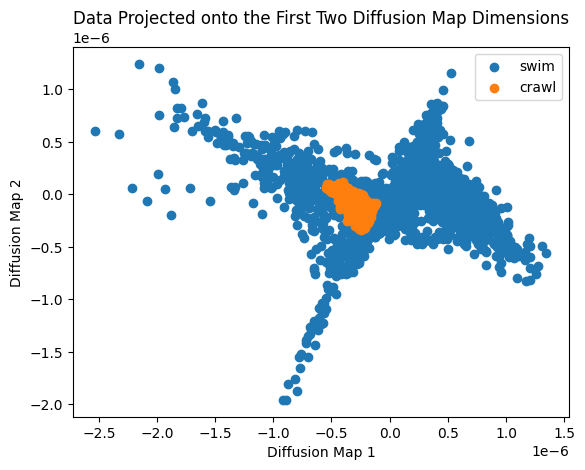

In [151]:
# Get unique types
types = df['type'].unique()

# Create a scatter plot for each type
for type in types:
    mask = df['type'] == type
    plt.scatter(diffusion_map[mask, 0], diffusion_map[mask, 1], label=type)

plt.xlabel('Diffusion Map 1')
plt.ylabel('Diffusion Map 2')
plt.title('Data Projected onto the First Two Diffusion Map Dimensions')
plt.legend()
plt.show()